In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import pandas as pd

from scipy.special import logsumexp
from scipy.stats import norm, expon, binom, poisson, geom

In [8]:
def normalize(array, axis):
    return array / array.sum(axis=axis, keepdims=True)


def logdotexp(A, B):
    """
    Equivalent to: Exponentiate A and B, do a dot product, then log them
    But more stable
    """
    max_A = np.max(A)
    max_B = np.max(B)
    C = np.dot(np.exp(A - max_A), np.exp(B - max_B))
    np.log(C, out=C)
    C += max_A + max_B
    return C


def lognormalize(array, axis):
    return array - logsumexp(array, axis=axis, keepdims=True)


def log_basic_RSA(language_binary, listener_prior, alpha=4, costs=None):
    if costs is None:
        costs = np.zeros(len(language_binary))
    l0_binary = normalize(language_binary*listener_prior[None], axis=1)
    utility_binary = np.log(l0_binary)
    costs_unnorm = np.exp(-costs.reshape(-1,1))
    costs = normalize(costs_unnorm, axis=0)
    unnorm_s1_binary = np.exp(alpha * utility_binary) * costs
    s1_binary = normalize(unnorm_s1_binary, axis=0) 
    l1_binary = normalize(s1_binary*listener_prior[None], axis=1)
    return np.log(l0_binary), np.log(s1_binary), np.log(l1_binary)


def log_RSA_speaker(log_l, alpha):
    # here I am implicity exponentiating it (i.e returning to normal space)
    utility_graded = np.where(log_l==-np.inf, -np.inf, log_l)
    # here it gets multiplied, then exponentiated, then back into log space
    # but the exp and log simplify
    log_unnorm_s = alpha * utility_graded
    log_s = lognormalize(log_unnorm_s, axis=0)
    return log_s

In [9]:
def listener_to_speaker_single(l1, costs, rho=4):
    """
    This function takes a pragmatic listener and models
    their production behaviour in the experimental task
    
    In the experiment, the participants receives a signal and
    has to produce a signal themselves. 
    The idea here is that the participant
    samples the signal from their posterior distribution,
    with an additional cost for producing less round numbers.
    
    Parameters
    ----------
    l1: array
        Array with shape (# signals, # states). 
        Each row is a probability vector
    costs: array
        Array with len (# signals)
        The cost of each numeral
    """
    unnorm = np.exp(np.log(l1)*rho - costs.reshape(1,-1))
    return normalize(unnorm,1)
    

def listener_to_speaker_bound(l1, costs, rho=4, clip=0.99):
    """
    This function takes a pragmatic listener
    and outputs a distribution over bounds
    TODO: write this function
    """
    cumsum = np.cumsum(l1, axis=1)
    cumsum[cumsum>clip] = 0
    norm_cumsum = normalize(cumsum,1)
    unnorm = np.exp(np.log(norm_cumsum)*rho - costs.reshape(1,-1))
    return normalize(unnorm,1)

In [6]:
def calculate_cost(integers, roundness_divisors = np.array([100, 50, 10, 5, 1])):
    """
    The idea is that cost is an inverse of roundness,
    i.e. numbers divisible by 10, 20, 50, and 100 simpler.
    Equation (2) in Hesse and Benz (2020), but reversed
    because I am calculating cost rather than roundness.
    NOTE: this is a vectorized function
    """    
    # create an array with shape (# roundness levels, # integers) 
    # that encodes divisibility
    divisibility = (integers % roundness_divisors.reshape(-1,1))==0
    # identify the highest roudness level for each integer
    costs = np.argmax(np.cumsum(divisibility, axis=0)>0, axis=0)
    return costs

def create_more_than_language(size, granularity, return_compatibility=False):
    # granularity means how far away the signals are to each other
    # the language array has shape (# signals, # states)
    # np.triu here creates an array with 1s above the main diagonal
    language = np.triu(np.ones((size,size)))[::granularity]
    if not return_compatibility:
        return language
    Xs, Ys = np.mgrid[0:len(language),0:len(language)]
    # if the index for both x and y is a multiple or 10, 
    # or if the x index is not a multiple of 10
    compatibility_array = ((Xs%10==0)&(Ys%10==0))|(Xs%10!=0)
    return language, compatibility_array
    

def create_exactly_language(size, granularity, return_compatibility=False):
    language = np.row_stack((
        np.ones(size),
        np.eye(size,size)[::granularity]
    ))
    if not return_compatibility:
        return language
    Xs, Ys = np.mgrid[0:len(language),0:len(language)]
    compatibility_array = ((Xs%10==0)&(Ys%10==0))|(Xs%10!=0)
    return language, compatibility_array

# Models

Priors

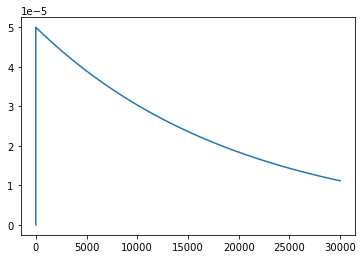

In [13]:
xs = np.arange(30000)
plt.plot(xs, geom.pmf(xs,0.00005))

In [10]:
size = 1000
language = create_more_than_language(size, 1)
costs = calculate_cost(
    np.arange(size),
    roundness_divisors = np.array([
        1000, 500, 200, 
        100, 50, 10, 5, 1
    ])
)
prior = geom.pmf(np.arange(1,size+1),0.007)

_,_, l1 = np.exp(log_basic_RSA(
    language, 
    listener_prior=prior,
    alpha=7, 
    costs=costs
))


# Since all columns need to apply to at least one value, 
# signal 0 means "more than 0"
# but state 0 refers to number 1
# (otherwise the first column would be all 0s)

# To make it such that the index corresponds to the number, I add a column of 0s as the first column
l1 = np.column_stack((np.zeros(len(l1)),l1[:,:-1]))

<ipython-input-8-aa0e23a83b91>:26: RuntimeWarning: divide by zero encountered in log
  utility_binary = np.log(l0_binary)
<ipython-input-8-aa0e23a83b91>:32: RuntimeWarning: divide by zero encountered in log
  return np.log(l0_binary), np.log(s1_binary), np.log(l1_binary)


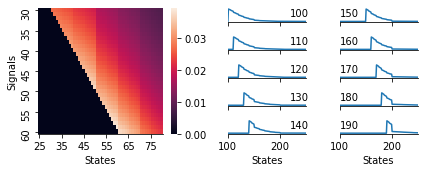

In [11]:
fig, axes = plt.subplots(
    5,3, 
    sharex=True, 
    figsize=(6,2.5),
    gridspec_kw={'width_ratios':[2]+[1]*2}
)

###### plot the heatmap

gs = axes[0, 0].get_gridspec()
# remove the underlying axes
for ax in axes[:,0]:
    ax.remove()

ax_heatmap = fig.add_subplot(gs[:, 0])

(ymin, ymax), (xmin, xmax) = (30,61), (25,81)
df = pd.DataFrame(
    l1[ymin:ymax,xmin:xmax],
    index=np.arange(ymin,ymax),
    columns=np.arange(xmin,xmax)
)
sns.heatmap(
    df,
    xticklabels=10,
    yticklabels=5,
    ax=ax_heatmap,
#     cbar_kws = dict(use_gridspec=False,location="top")
)

ax_heatmap.set_xlabel('States')
ax_heatmap.set_ylabel('Signals')

######## plot the single distributions

for i, ax in enumerate(axes[:,1:].T.flatten()):
    n = 100+i*10
    ax.plot(l1[n])
    ax.text(
        0.8 if i<5 else 0., 
        0.4,
        n,
        transform=ax.transAxes
    )
    ax.set_xlim(100,250)

sns.despine(fig, left=True)
[a.set_yticks([]) for a in axes.flatten()]
axes[-1,1].set_xlabel('States')
axes[-1,2].set_xlabel('States')
fig.subplots_adjust(bottom=0.2,)
fig.tight_layout()
# plt.savefig('l1_morethan.png', dpi=300)
plt.show()

In [148]:
production_p = listener_to_speaker_single(l1, costs, rho=3)

<ipython-input-39-354c016e9fe2>:21: RuntimeWarning: divide by zero encountered in log
  unnorm = np.exp(np.log(l1)*rho - costs.reshape(1,-1))
<ipython-input-38-56f88398daac>:2: RuntimeWarning: invalid value encountered in true_divide
  return array / array.sum(axis=axis, keepdims=True)


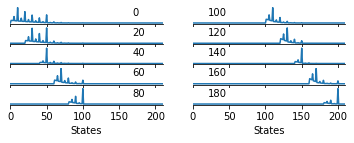

In [149]:
fig, axes = plt.subplots(5,2, sharex=True, figsize=(6,2))

for i, ax in enumerate(axes.T.flatten()):
    ax.plot(production_p[i*20])
    ax.text(
        0.8 if i<5 else 0.1, 
        0.5,
        i*20,
        transform=ax.transAxes
    )
sns.despine(fig, left=True)
[a.set_yticks([]) for a in axes.flatten()]
[a.set_xlim(0,210) for a in axes.flatten()]
[a.set_xlabel('States') for a in axes[-1,:].flatten()]
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.savefig('productionProbs.png', dpi=300)

In [290]:
production_c = listener_to_speaker_bound(l1, costs, rho=7)

<ipython-input-38-56f88398daac>:2: RuntimeWarning: invalid value encountered in true_divide
  return array / array.sum(axis=axis, keepdims=True)
<ipython-input-287-f546bbfe3de0>:34: RuntimeWarning: divide by zero encountered in log
  unnorm = np.exp(np.log(norm_cumsum)*rho - costs.reshape(1,-1))


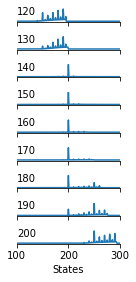

In [294]:
fig, axes = plt.subplots(
    9,1, 
    sharex=True, 
    figsize=(2,4)
)

numerals_to_plot = np.arange(120,201,10)
for i, ax in zip(numerals_to_plot, axes.T.flatten()):
    ax.plot(production_c[i])
    ax.text(
        0., 
        0.5,
        i,
        transform=ax.transAxes
    )
sns.despine(fig, left=True)
[a.set_yticks([]) for a in axes.flatten()]
[a.set_xlim(100,300) for a in axes.flatten()]
axes[-1].set_xlabel('States')
fig.tight_layout()
fig.savefig('boundsProbs.png', dpi=300)

## Large numerals

In [6]:
size = 10000
language = create_more_than_language(size, 1)

costs = calculate_cost(
    np.arange(size), 
    roundness_divisors = np.array([
        1000, 500, 200, 
        100, 50, 10, 5, 1
    ])
)

prior_small = geom.pmf(np.arange(1,size+1),0.007)
prior_big = geom.pmf(np.arange(1,size+1),0.0002)

_,_, l1_small = np.exp(log_basic_RSA(language, listener_prior=prior_small, alpha=10, costs=costs))
_,_, l1_big = np.exp(log_basic_RSA(language, listener_prior=prior_big, alpha=10, costs=costs))

l1_small = np.column_stack((np.zeros(len(l1_small)),l1_small[:,:-1]))
l1_big = np.column_stack((np.zeros(len(l1_big)),l1_big[:,:-1]))

<ipython-input-2-56f88398daac>:26: RuntimeWarning: divide by zero encountered in log
  utility_binary = np.log(l0_binary)
<ipython-input-2-56f88398daac>:30: RuntimeWarning: divide by zero encountered in log
  return np.log(l0_binary), np.log(s1_binary), np.log(l1_binary)


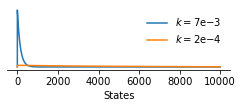

In [37]:
fig, ax_dists = plt.subplots(figsize=(4,1.5))
xs = np.arange(10000)
ax_dists.plot(xs, geom.pmf(xs,0.007), label=r'$k=7\mathrm{e}{-3}$')
ax_dists.plot(xs, geom.pmf(xs,0.0002), label=r'$k=2\mathrm{e}{-4}$')
ax_dists.set_yticks([])
ax_dists.set_xlabel('States')
ax_dists.legend(frameon=False)
sns.despine(fig, left=True)
# plt.show()
# fig.tight_layout()
fig.subplots_adjust(bottom=0.3)
fig.savefig('priors.png', dpi=300)

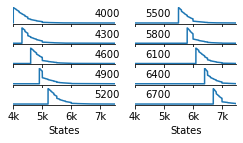

In [38]:
fig, axes = plt.subplots(
    5,2, 
    sharex=True, 
    figsize=(4,2),
#     gridspec_kw={'width_ratios':[2,2,1]}
)

numerals_to_show = np.arange(4000,7001,300)

for i, ax in zip(numerals_to_show, axes.T.flatten()):
    ax.plot(l1_big[i])
    ax.text(
        0.8 if i<5500 else 0.1, 
        0.4,
        i,
        transform=ax.transAxes
    )

[a.set_yticks([]) for a in axes.flatten()]
[a.set_xlim(4000,7500) for a in axes[:,0].flatten()]
[a.set_xticks([4000, 5000, 6000, 7000]) for a in axes[:,0].flatten()]
[a.set_xticklabels(['4k', '5k', '6k', '7k']) for a in axes[:,0].flatten()]
[a.set_xlabel('States') for a in axes[-1].flatten()]
sns.despine(fig, left=True)
# fig.subplots_adjust(
#     bottom=0.2, 
#     left=0.05, 
#     right=0.95
# )
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.savefig('largeNumeralsDist.png', dpi=300)
# plt.show()

## Other plots

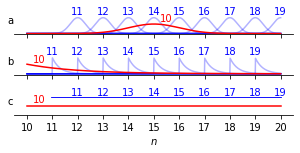

In [301]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(5,2))
xs = np.linspace(10,20,1000)

####### top plot (normal-like)

for i in range(11,20):
    mean = i+1
    ax1.plot(
        xs, 
        norm.pdf(xs,loc=mean,scale=0.3),
        color='blue',
        alpha=0.3
    )
    ax1.text(
        mean,
        1.6,
        i,
        horizontalalignment='center',
        color='blue'
    )
ax1.plot(
    xs, 
    norm.pdf(xs,loc=15,scale=1)*2,
    color='red'
)
ax1.text(
    15.5,
    1,
    10,
    horizontalalignment='center',
    color='red'
)

ax1.set_ylabel('a', rotation=0)

####### middle plot (exponential-like)

for i in range(11,20):
    mean = i
    ax2.plot(
        xs, 
        expon.pdf(xs,loc=mean,scale=0.3),
        color='blue',
        alpha=0.3
    )
    ax2.text(
        mean,
        4,
        i,
        horizontalalignment='center',
        color='blue'
    )

ax2.plot(
    xs, 
    expon.pdf(xs,loc=10,scale=2)*4,
    color='red'
)
ax2.text(
    10.5,
    2.5,
    10,
    horizontalalignment='center',
    color='red'
)

ax2.set_ylabel('b', rotation=0)

####### bottom plot (uniform-like)
ax3.set_ylim(0)
local_xs = np.linspace(11,20,1000)
for i in range(11,20):
    mean = i+1
    ax3.plot(
        local_xs, 
        [1]*len(local_xs),
        color='blue',
        alpha=0.3
    )
    ax3.text(
        mean,
        1.1,
        i,
        horizontalalignment='center',
        color='blue'
    )

ax3.plot(
    xs, 
    [0.5]*len(xs),
    color='red'
)
ax3.text(
    10.5,
    0.7,
    10,
    horizontalalignment='center',
    color='red'
)

ax3.set_ylabel('c', rotation=0)

ax3.set_xlabel('$n$')
sns.despine(fig, left=True)
[a.set_yticks([]) for a in [ax1,ax2,ax3]]
ax3.set_xticks(np.arange(10,21))
fig.subplots_adjust(hspace=1.3,bottom=0.2)

fig.savefig('possibleDistributions.png', dpi=300)

# Hesse & Benz (2020) data

In [18]:
import pandas as pd

In [29]:
df_exp_3 = pd.read_csv('HesseBenz2020/exp3.csv', sep=r"\t")

<ipython-input-29-9f4ddb3601e5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_exp_3 = pd.read_csv('HesseBenz2020/exp3.csv', sep=r"\t")


- p: most likely value
- c: shown numeral
- q: quantifier (more than / less than)
- r: roundness
- lb: lower bound of range
- up: upper bound of range
- ib: upper bound if quantifier is 'more than', lower bound if quantifier is 'less than'
- int_lbub: interval lower bound to upper bound
- int_cib: interval c to relevant boundary i
- int_cp: interval c to p

In [61]:
df_exp_3[df_exp_3['participant']==1003]

,id,participant,c,q,r,lb,p,ub,ib,int_lbub,int_cib,int_cp,interpret
2,3,1003,19000,>,3,19000,19500.0,50000,50000,31000,31000,500.0,prag
52,53,1003,16000,<,3,0,15999.0,16000,0,16000,16000,1.0,sem
102,103,1003,25000,>,4,25000,26000.0,50000,50000,25000,25000,1000.0,prag
152,153,1003,1000,<,5,0,900.0,1000,0,1000,1000,100.0,sem
202,203,1003,1100,<,3,1000,1099.0,1099,1000,99,100,1.0,prag


In [34]:
np.sort(df_exp_3['c'].unique())

array([ 1000,  1100,  1400, 15000, 16000, 19000, 20000, 21000, 24000,
       25000], dtype=int64)

In [127]:
df_exp_3.shape

(1000, 13)

In [126]:
df_exp_3.loc[(df_exp_3['p']%500 > 0) & (df_exp_3['p']>15000)].reset_index()

,index,id,participant,c,q,r,lb,p,ub,ib,int_lbub,int_cib,int_cp,interpret
0,19,20,1020,19000,>,3,19100,19400.0,20000,20000,900,1000,400.0,prag
1,24,25,1025,19000,>,3,18000,19200.0,20000,20000,2000,1000,200.0,prag
2,35,36,1036,19000,>,3,19000,19750.0,20000,20000,1000,1000,750.0,prag
3,38,39,1039,19000,>,3,19001,19001.0,20000,20000,999,1000,1.0,prag
4,50,51,1001,16000,<,3,15000,15600.0,16000,15000,1000,1000,400.0,prag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,928,929,4029,20000,>,5,20001,25690.0,50000,50000,29999,30000,5690.0,prag
85,969,970,4020,25000,<,4,23000,24555.0,24230,23000,1230,2000,445.0,prag
86,978,979,4029,25000,<,4,1,24589.0,24999,1,24998,24999,411.0,sem
87,984,985,4035,25000,<,4,24000,24800.0,24999,24000,999,1000,200.0,prag


In [101]:
(df_exp_3.loc[df_exp_3['p']>=15000,['p']]%500).value_counts()

p    
0.0      497
100.0     13
200.0     11
250.0      9
300.0      8
50.0       7
400.0      5
1.0        4
55.0       3
299.0      2
265.0      2
104.0      1
482.0      1
89.0       1
69.0       1
478.0      1
122.0      1
43.0       1
42.0       1
25.0       1
10.0       1
106.0      1
190.0      1
143.0      1
178.0      1
453.0      1
495.0      1
232.0      1
275.0      1
280.0      1
330.0      1
345.0      1
360.0      1
374.0      1
436.0      1
499.0      1
dtype: int64